# Task 2: Volatility Forecasting

**Objective**: Model and forecast the volatility of Brent oil prices using a Bayesian Stochastic Volatility model.

**Approach**:
1. Load and prepare log returns data
2. Visualize volatility clustering (squared returns)
3. Build a Stochastic Volatility model using PyMC
4. Estimate latent volatility over time
5. Forecast future volatility

## 1. Setup and Data Loading

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az

import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Libraries loaded")

✓ Libraries loaded


In [13]:
# Load data
df = pd.read_csv('../data/raw/BrentOilPrices.csv')
df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=True)
df = df.sort_values('Date').reset_index(drop=True)

# Focus on 2012-2022
df_recent = df[df['Date'] >= '2012-01-01'].copy()

# Calculate log returns
df_recent['Log_Return'] = np.log(df_recent['Price'] / df_recent['Price'].shift(1))
df_recent = df_recent.dropna()

returns = df_recent['Log_Return'].values
dates = df_recent['Date'].values

print(f"Data: {len(returns)} observations")
print(f"Returns stats: Mean={returns.mean():.5f}, Std={returns.std():.5f}")

Data: 2759 observations
Returns stats: Mean=-0.00006, Std=0.02948


## 2. Volatility Analysis

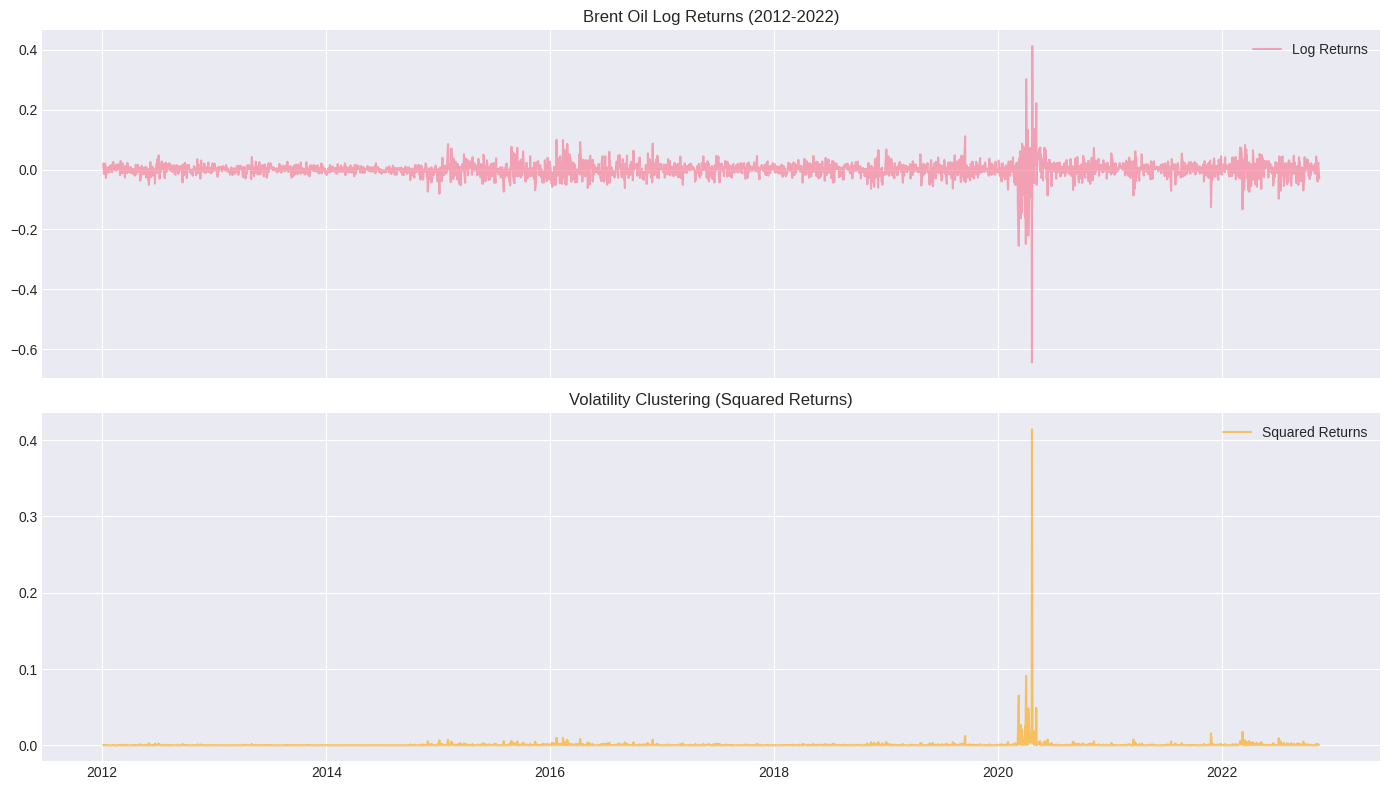

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

ax[0].plot(dates, returns, alpha=0.6, label='Log Returns')
ax[0].set_title('Brent Oil Log Returns (2012-2022)')
ax[0].legend()

ax[1].plot(dates, returns**2, alpha=0.6, color='orange', label='Squared Returns')
ax[1].set_title('Volatility Clustering (Squared Returns)')
ax[1].legend()

plt.tight_layout()
plt.savefig('../results/figures/volatility_clustering.png')
plt.show()

## 3. Bayesian Stochastic Volatility Model

We model the log returns $y_t$ as dependent on a latent log-volatility process $s_t$.

$$ y_t \sim \text{StudentT}(\nu, 0, \exp(s_t)) $$
$$ s_t \sim \text{GaussianRandomWalk}(\sigma) $$

This captures:
- Time-varying volatility
- Heavy tails (Student-T)

In [15]:
# Standardize returns for better convergence
returns_std = (returns - returns.mean()) / returns.std()

with pm.Model() as sv_model:
    # Nu (degrees of freedom) for heavy tails
    nu = pm.Exponential('nu', 0.1)
    
    # Volatility process standard deviation
    sigma = pm.Exponential('sigma', 10.0)
    
    # Latent log volatility process (Gaussian Random Walk)
    # Latent log volatility process (Gaussian Random Walk)
    # Manual implementation to avoid PyTensor OverflowError
    step_s = pm.Normal('step_s', 0.0, sigma=sigma, shape=len(returns))
    s = pm.Deterministic('s', step_s.cumsum())
    
    # Likelihood
    # exp(s) is the volatility (scale)
    r = pm.StudentT('r', nu=nu, mu=0, sigma=pm.math.exp(s), observed=returns_std)

print("✓ Stochastic Volatility Model built")
# print(pm.model_to_graphviz(sv_model))

✓ Stochastic Volatility Model built


In [16]:
%%time
with sv_model:
    # Using NUTS sampler
    trace_sv = pm.sample(
        draws=500, 
        tune=500, 
        chains=2, 
        target_accept=0.9,
        return_inferencedata=True,
        random_seed=42
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, sigma, step_s]


Output()

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 949 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


CPU times: user 3min 22s, sys: 8.84 s, total: 3min 31s
Wall time: 16min 8s


## 4. Latent Volatility Estimation

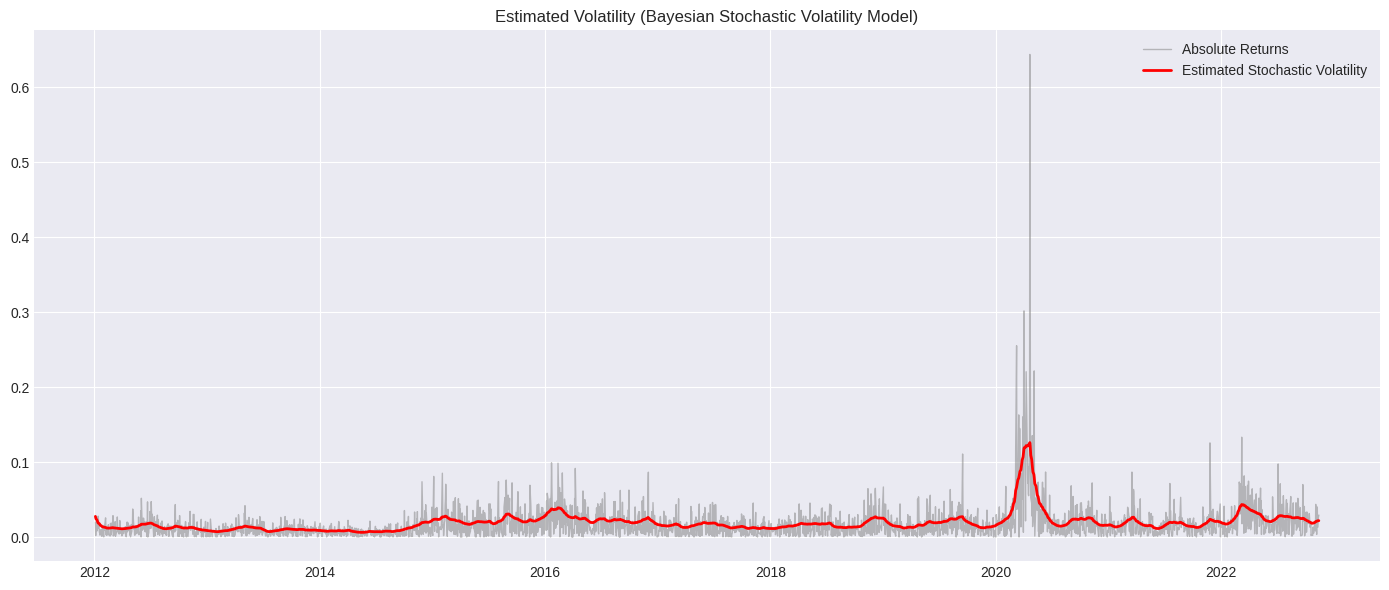

In [17]:
# Extract posterior of log volatility 's'
posterior_s = trace_sv.posterior['s'].mean(dim=['chain', 'draw']).values

# Convert back to original scale standard deviation
# volatility = exp(s) * original_std
volatility_estimated = np.exp(posterior_s) * returns.std()

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(dates, np.abs(returns), alpha=0.5, label='Absolute Returns', color='gray', lw=1)
ax.plot(dates, volatility_estimated, label='Estimated Stochastic Volatility', color='red', lw=2)
ax.set_title('Estimated Volatility (Bayesian Stochastic Volatility Model)')
ax.legend()
plt.tight_layout()
plt.savefig('../results/figures/estimated_stochastic_volatility.png')
plt.show()

## 5. Insight: High Volatility Periods

In [18]:
# Create dataframe of estimated volatility
vol_df = pd.DataFrame({'Date': dates, 'Volatility': volatility_estimated})

# Find top 5 high volatility periods
top_vol = vol_df.sort_values('Volatility', ascending=False).head(10)
print("Top High Volatility Dates:")
print(top_vol)

# Save volatility data
vol_df.to_csv('../data/processed/stochastic_volatility_estimates.csv', index=False)
print("✓ Volatility estimates saved")

Top High Volatility Dates:
           Date  Volatility
2107 2020-04-21    0.125937
2106 2020-04-20    0.124597
2105 2020-04-17    0.123248
2108 2020-04-22    0.122232
2104 2020-04-16    0.122012
2101 2020-04-09    0.121928
2103 2020-04-15    0.121578
2102 2020-04-14    0.121434
2100 2020-04-08    0.120825
2099 2020-04-07    0.119953
✓ Volatility estimates saved
